In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
import pandas as pd

import scipy.integrate as integrate
import scipy.special as special

import random as random
import scipy.optimize as optimize

import importlib
import gc

In [45]:
import Functions_Xyloportas as f # All functions we will use

In [46]:
# Update any changes in Functions_Xyloportas.py file
importlib.reload(f)
#help(f)

<module 'Functions_Xyloportas' from 'C:\\Users\\XYLOPORTAS\\Desktop\\Φυσικό ΕΚΠΑ (2020-2024)\\8ο Εξάμηνο\\Πτυχιακή Εργασία\\Latex_code\\Functions_Xyloportas.py'>

In [39]:
# Parameters (Units: cgs)
st = 0.665245*(10**-24) # Thomson scattering cross section
c = 2.997925*(10**10) # speed of light
m = 9.10956*(10**-28) # mass of particles (electron)
q = 4.80325*(10**-10) # charge of particles (electron)
pi = math.pi

#A = (st*(B**2))/(6*np.pi*m*c)
#w_B = (q*B)/(m*c) # ω_B gyro-frequency
#tr = (gmax-gmin)/(A*gmax*gmin) #t_r (sec)

h = 6.625*10**-27 # Planck constant (erg*sec)
ev_to_erg = 1.602162*10**-12 # erg/eV
erg_to_ev = 1/ev_to_erg # eV/erg
kev_to_erg = ev_to_erg/(10**-3) # erg/keV
erg_to_kev = (10**-3)/ev_to_erg # keV/erg

print("1 erg = %0.2e keV" %erg_to_kev)
print("1 keV = %0.2e erg" %kev_to_erg)

1 erg = 6.24e+08 keV
1 keV = 1.60e-09 erg


In [5]:
# Import Spectral Breaks
SpectralBreaksA = pd.read_csv('./SpectralBreaks/SpBrA.txt', delimiter='\t') # t<40s
print(SpectralBreaksA)
TimeA = SpectralBreaksA["Time"] # sec
TimeerA = SpectralBreaksA["Timeer"] # sec
EbA = SpectralBreaksA["Eb"] # keV
EberA = SpectralBreaksA["Eber"] # keV
EpA = SpectralBreaksA["Ep"] # keV
EperA = SpectralBreaksA["Eper"] # keV

SpectralBreaksB = pd.read_csv('./SpectralBreaks/SpBrB.txt', delimiter='\t') # t>40s
print(SpectralBreaksB)
TimeB = SpectralBreaksB["Time"] # sec
TimeerB = SpectralBreaksB["Timeer"] # sec
EpB = SpectralBreaksB["Ep"] # keV
EperB = SpectralBreaksB["Eper"] # keV

    Time  Timeer    Eb  Eber      Ep   Eper
0    1.0     1.0  21.0   8.8  2411.3  602.0
1    3.0     1.0  46.7   8.2   951.6   47.4
2    5.0     1.0  30.7   3.3   721.0   47.5
3    7.0     1.0  64.3   4.9  1543.0   47.5
4    9.0     1.0  30.0   2.7  1053.6   72.0
5   11.0     1.0  28.5   2.4   567.1  135.7
6   14.0     2.0  19.9   3.6   257.3  205.7
7   17.0     1.0  20.6   4.2   275.0   40.9
8   19.0     1.0  27.2   2.8   580.0   86.5
9   21.0     1.0  23.8   2.9   319.6   45.8
10  23.0     1.0  24.2   2.6   335.2   51.5
11  25.0     1.0  24.8   2.7   305.5   47.9
12  28.0     2.0  24.3   0.9    83.9   30.3
13  32.0     2.0  17.2   3.7    69.8   16.9
14  36.0     2.0  20.2   1.6   225.6   50.9
15  40.0     2.0  17.6   4.2    76.3   15.9
     Time  Timeer     Ep  Eper
0    44.0     2.0  37.70  3.06
1    48.0     2.0  42.20  5.61
2    55.0     5.0  35.50  2.29
3    65.0     5.0  36.40  4.32
4    85.0     5.0   7.74  0.81
5    95.0     5.0   5.81  0.83
6   105.0     5.0   4.59  0.54
7   

## Markov Chain Monte Carlo (MCMC): fit Spectral Breaks

In [6]:
import emcee
import corner
from IPython.display import display, Math

In [7]:
# Spectral Breaks data
x1 = TimeA # time (sec): t_obs
y1 = EpA # Spectral break E_p (keV): Ep_obs
yerr1 = EperA # E_p error
x2 = TimeA # time (sec): t_obs
y2 = EbA # Spectral break E_b (keV): Ep_obs
yerr2 = EberA # E_b error

- **Likelihood** function for model $y = G(x|param)$: $Likelihood(y|x,σ,param)$<br>
$ln (L(y|x,σ,param)) = - \dfrac{1}{2} \sum_{n} \left[ \dfrac{(y_n - G(x_n))^2}{s_n^2} + ln(2π s_n^2) \right] $  ,  where: $s_n^2 = σ_n^2 + f^2 G^2(x_n)$ <br>
This likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount $f$.

- (uninformative) **Prior**: <br>
$Prior(param) = 
\begin{cases}
\frac{1}{param_{max}-param_{min}}  \quad , \quad if \ param_{min}\leq param \leq param_{max}\\
0 \quad , \quad otherwise
\end{cases}$

- full Probability function (**Posterior**): <br>
$Posterior(param|x,y,σ) \propto Likelihood(y|x,σ,param) \cdot Prior(param)$

We cannot draw parameter samples from the likelihood function, thus we sample the full log-probability posterior function using ``emcee``.

For a more detailed explanation of MCMC, see $\href{https://emcee.readthedocs.io/en/stable/tutorials/line/}{emcee: Fitting \ a \ model \ to \ data.}$

### **Model 1**: $E_p \sim \gamma_{max}(t)$ & $E_b \sim \gamma_{min}(t)$

In [8]:
# log-Likelihood function (γ_max(t) - E_p) 
def log_likelihood_gmaxt(log_D, log_B, log_gmax, log_f, x, y, yerr):
    #log_D, log_B, log_gmax, log_f = theta
    model = erg_to_kev*(10**log_D)*h*(q*(10**log_B)/(2*pi*m*c))*(((10**log_gmax)/(1+((st*(10**log_gmax)*x*(10**log_D)*(10**log_B)**2)/(6*m*c*pi))))**2)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#     if np.any(sigma2 <= 0):
#         print(f"Invalid sigma2: {sigma2}")
#         return -np.inf
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(2*np.pi*sigma2))
# log-Likelihood function (γ_min(t) - E_b)
def log_likelihood_gmint(log_D, log_B, log_gmin, log_f, x, y, yerr):
    #log_D, log_B, log_gmin, log_f = theta
    model = erg_to_kev*(10**log_D)*h*(q*(10**log_B)/(2*pi*m*c))*(((10**log_gmin)/(1+((st*(10**log_gmin)*x*(10**log_D)*(10**log_B)**2)/(6*m*c*pi))))**2)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#     if np.any(sigma2 <= 0):
#         print(f"Invalid sigma2: {sigma2}")
#         return -np.inf
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(2*np.pi*sigma2))
# log-Likelihood function: for both Spectral Breaks
def log_likelihood_model_tt(params, x1, y1, yerr1, x2, y2, yerr2):
    log_D, log_B, log_gmax, log_gmin, log_f = params
    ll1 = log_likelihood_gmaxt(log_D, log_B, log_gmax, log_f, x1, y1, yerr1)
    ll2 = log_likelihood_gmint(log_D, log_B, log_gmin, log_f, x2, y2, yerr2)
    return ll1 + ll2
# log-Prior function (restrict the range of parameters)
def log_prior(params):
    log_D, log_B, log_gmax, log_gmin, log_f = params
    if 1.5 < log_D < 3.0 and -2.0 < log_B < 1.0 and 5.0 < log_gmax < 7.0 and 4.0 < log_gmin < 6.0 and -10.0 < log_f < 1.0:
        return 0.0 # Uniform prior
    #print(f"Out-of-bounds parameters: {params}")
    return -np.inf # Outside the bounds
# Probability function = Prior*Likelihood
def log_probability_tt(params, x1, y1, yerr1, x2, y2, yerr2):
    log_D, log_B, log_gmax, log_gmin, log_f = params
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll1 = log_likelihood_gmaxt(log_D, log_B, log_gmax, log_f, x1, y1, yerr1)
    ll2 = log_likelihood_gmint(log_D, log_B, log_gmin, log_f, x2, y2, yerr2)
    return lp + ll1 + ll2

In [9]:
# The "true" (initial) parameters (here use results from scipy.curve_fit). All values are in log10.
D_true1 = np.log10(289.1)
B_true1 = np.log10(0.410)
gmax_true1 = np.log10(1.135*10**6)
gmin_true1 = np.log10(1.672*10**5)
log_f_true1 = -1.03 # random value
solnx1 = [0]*5
solnx1 = [D_true1, B_true1, gmax_true1, gmin_true1, log_f_true1] # array with "true" values (initial guess)
print("Model 1: γ_max(t) & γ_min(t)")
print("D_true1, B_true1, gmax_true1, gmin_true1, log_f_true1 [all in log]")
print(solnx1)

Model 1: γ_max(t) & γ_min(t)
D_true1, B_true1, gmax_true1, gmin_true1, log_f_true1 [all in log]
[2.461048091670658, -0.38721614328026455, 6.054995861529141, 5.223236273102998, -1.03]


In [11]:
pos = solnx1 + 1e-2 * np.random.randn(32, 5) # Here we have 5 parameters, choose 32 initial positions
nwalkers1, ndim1 = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers1, ndim1, log_probability_tt, args=(x1, y1, yerr1, x2, y2, yerr2)
)
sampler.run_mcmc(pos, 6000, progress=True);

100%|██████████| 6000/6000 [09:55<00:00, 10.07it/s]


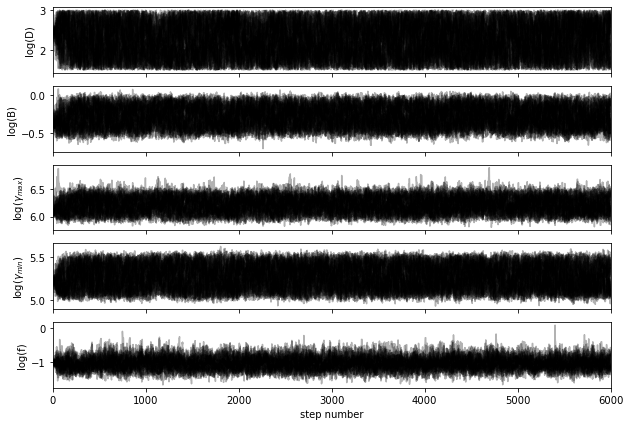

In [12]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["log(D)", "log(B)",  r"log($γ_{max}$)", r"log($γ_{min}$)", "log(f)"]
for i in range(ndim1): # ndim1 = number of parameters
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [ ]:
#Checks/Tests

# print(pos.shape)
# print(pos) # 5 parameters, 32 initial positions
# print(f"Walker positions: {pos.shape}")  # Should be (nwalkers1, ndim1)

# print(samples)

In [13]:
# Steps needed for the chain to “forget” where it started
tau = sampler.get_autocorr_time()
print("tau=",tau) 
# Error message to avoid:
# The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). 
# Use this estimate with caution and run a longer chain! N/50 = 20;

# Discard initial 100 steps,
# thin chain by about half the autocorrelation time (i.e.30 steps) & flatten the chain, so that we have a flat list of sample:
flat_samples1 = sampler.get_chain(discard=100, thin=30, flat=True)
print(flat_samples1.shape)

tau= [72.55387684 71.55314598 70.99151448 74.94255788 55.97848699]
(6272, 5)


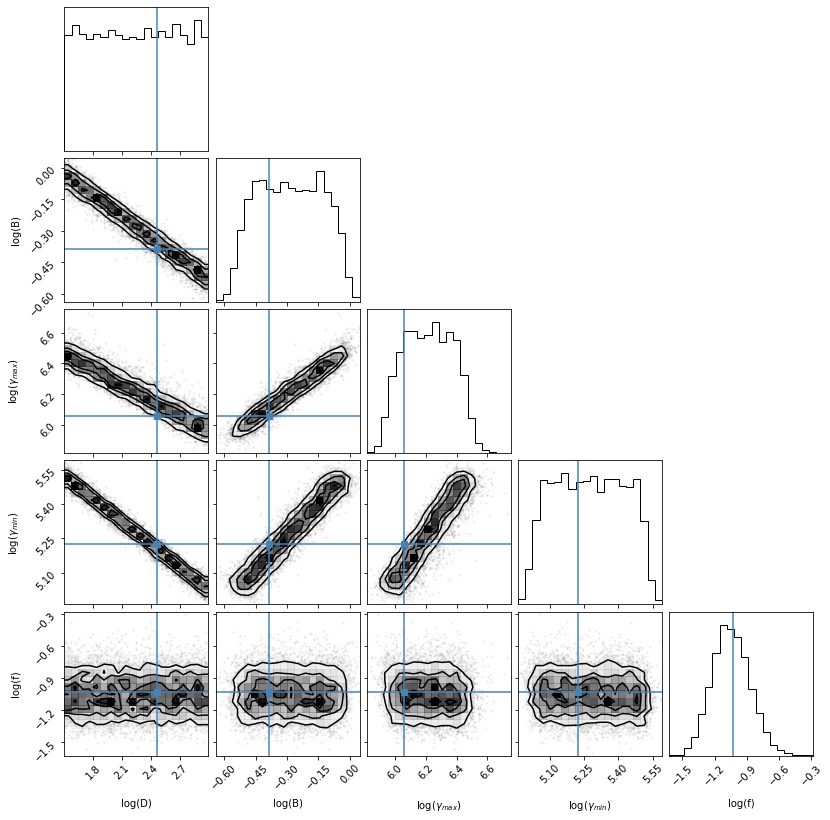

In [14]:
fig1 = corner.corner(
    flat_samples1, labels=labels, truths=[D_true1, B_true1, gmax_true1, gmin_true1, log_f_true1]
);
#plt.savefig('GRB211211A_MCMC1_corner.png')

In [15]:
# Quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions. 
for i in range(ndim1):
    mcmc = np.percentile(flat_samples1[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
# de-log
labels_delog = ["D", "B",  r"$γ_{max}$", r"$γ_{min}$", "f"]
for i in range(ndim1):
    mcmc = np.percentile(flat_samples1[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3e}_{{-{1:.3e}}}^{{+{2:.3e}}}"
    txt = txt.format(10**mcmc[1], 10**mcmc[1] - 10**mcmc[0] , 10**mcmc[2] - 10**mcmc[1], labels_delog[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Plot

In [17]:
t0 = np.linspace(1,50,100) # t_obs (sec)
t1 = np.linspace(1,200,200)
print("Model 1: γ_max(t) & γ_min(t)")
print("D_true1, B_true1, gmax_true1, gmin_true1, log_f_true1 [all in log]")
print(solnx1)
# print("D",10**solnx1[0])
# print("B",10**solnx1[1])
# print("gmax",10**solnx1[2])
# print("gmin",10**solnx1[3])

Model 1: γ_max(t) & γ_min(t)
D_true1, B_true1, gmax_true1, gmin_true1, log_f_true1 [all in log]
[2.461048091670658, -0.38721614328026455, 6.054995861529141, 5.223236273102998, -1.03]


In [18]:
# γ -> E_{obs} (keV)
def Eobs_fromg(g,D,B):
    E = D*h*q*B*(g**2)/(2*math.pi*m*c) # E_{obs}(erg)
    return E*erg_to_kev # E_{obs}(keV)
# E_{obs} (keV) -> γ 
def g_fromEobs(E,D,B):
    Eerg = E*kev_to_erg # E_{obs}(erg)
    return (2*math.pi*m*c*E/(D*h*q*B))**0.5 # γ

In [19]:
def fit_E_gt(tobs,go,BB,DD): # t = independent variable (t_obs)
    t = tobs*DD # t_obs = t_rest/D
    gg = f.g_evolutionB(go,t,BB) # = go/(1+((st*BB**2)/(6*m*c*pi))*go*t) = go/(1+A*go*t)    [γ(t)]
    # E = DD*h*(q*BB/(m*c))*(gg**2)/(2*pi) # E_obs (erg) = E_rest*D
    # E = DD*(q*BB/(m*c))*(gg**2)/(2*pi) # v_obs (Hz) = E_obs(erg)/h
    # E*erg_to_kev # E_obs (keV)
    return Eobs_fromg(gg,DD,BB) # E_obs (keV)

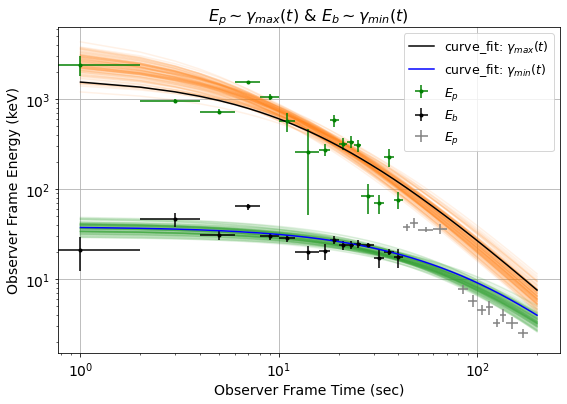

In [23]:
inds1 = np.random.randint(len(flat_samples1), size=100) #100 sample
fig1 = plt.figure(figsize=(9,6))
plt.title("$E_p \sim γ_{max}(t)$ & $E_b \sim γ_{min}(t)$", fontsize=16)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Observer Frame Time (sec)", fontsize=14)
plt.ylabel("Observer Frame Energy (keV)", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
for ind in inds1:
    sample = flat_samples1[ind]
    plt.plot(t1, fit_E_gt(t1,10**sample[2],10**sample[1],10**sample[0]), "C1", alpha=0.1)
    plt.plot(t1, fit_E_gt(t1,10**sample[3],10**sample[1],10**sample[0]), "C2", alpha=0.1)
plt.errorbar(x1, y1, yerr=yerr1, xerr=TimeerA, fmt=".g", capsize=0, elinewidth=1.5, label="$E_p$")
plt.errorbar(x2, y2, yerr=yerr2, xerr=TimeerA, fmt=".k", capsize=0, elinewidth=1.5,label="$E_b$")
plt.errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', c="0.5", elinewidth=1.5,label="$E_p$")
plt.plot(t1, fit_E_gt(t1, 10**gmax_true1, 10**B_true1, 10**D_true1), "k", label="curve_fit: $γ_{max}(t)$")
plt.plot(t1, fit_E_gt(t1, 10**gmin_true1, 10**B_true1, 10**D_true1), "b", label="curve_fit: $γ_{min}(t)$")
plt.legend(fontsize=12.5)
#plt.savefig('GRB211211A_SpectralBreaks_MCMC1.png')

In [24]:
# if we want to plot again: save "inds"
#print(inds1)
f = open("inds1_tt.txt", "w")
f.write("ind,D,B,gmax,gmin,f\n")
for i in range(len(inds1)):
    f.write(f"{inds1[i]},")
    sample = flat_samples1[inds1[i]]
    f.write(f"{10**sample[0]},")
    f.write(f"{10**sample[1]},")
    f.write(f"{10**sample[2]},")
    f.write(f"{10**sample[3]},")
    f.write(f"{10**sample[4]}\n")
f.close()
# sample[:3] prints first 3 parameters

data_inds1 = pd.read_csv('inds1_tt.txt', delimiter = ",")
data_inds1
#inds_txt = data_inds1["ind"]
#D_txt = data_inds1["D"]
#B_txt = data_inds1["B"]
#gmax_txt = data_inds1["gmax"]

,ind,D,B,gmax,gmin,f
0,3694,547.291629,0.330036,1.077743e+06,145025.552363,0.128750
1,50,611.363537,0.368006,1.285392e+06,121803.128668,0.095042
2,1473,720.709291,0.338096,9.420867e+05,105432.644157,0.148550
3,2211,44.112924,0.732356,2.596544e+06,300748.377883,0.121388
4,4193,983.910372,0.279567,9.582420e+05,117855.660960,0.052879
...,...,...,...,...,...,...
95,5197,220.219530,0.491033,1.412819e+06,166780.613368,0.085319
96,2455,137.599127,0.630362,1.994384e+06,187431.942244,0.097562
97,2422,464.223159,0.385316,9.905909e+05,145605.485089,0.100222
98,4440,37.069551,0.918495,2.915107e+06,325083.324609,0.154574


In [25]:
# AIC criterion
k1 = 5
log_prob_model1 = sampler.lnprobability
max_log_prob_model1 = np.max(log_prob_model1)
AIC1 = 2*k1 - 2*max_log_prob_model1
print("AIC for Model 1:", AIC1)

AIC for Model 1: 335.41360555378384


### **Model 2**: $E_p \sim \gamma_{max}(t)$ & $E_b \sim \gamma_{min}$

In [26]:
import Functions_Xyloportas as f # All functions we will use

In [38]:
# γ -> E_{obs} (keV)
def Eobs_fromg(g,D,B):
    E = D*h*q*B*(g**2)/(2*math.pi*m*c) # E_{obs}(erg)
    return E*erg_to_kev # E_{obs}(keV)
# E_{obs} (keV) -> γ 
def g_fromEobs(E,D,B):
    Eerg = E*kev_to_erg # E_{obs}(erg)
    return (2*math.pi*m*c*E/(D*h*q*B))**0.5 # γ
def fit_E_gt(tobs,go,BB,DD): # t = independent variable (t_obs)
    t = tobs*DD # t_obs = t_rest/D
    gg = f.g_evolutionB(go,t,BB) # = go/(1+((st*BB**2)/(6*m*c*pi))*go*t) = go/(1+A*go*t)    [γ(t)]
    # E = DD*h*(q*BB/(m*c))*(gg**2)/(2*pi) # E_obs (erg) = E_rest*D
    # E = DD*(q*BB/(m*c))*(gg**2)/(2*pi) # v_obs (Hz) = E_obs(erg)/h
    # E*erg_to_kev # E_obs (keV)
    return Eobs_fromg(gg,DD,BB) # E_obs (keV)

In [28]:
# log-Likelihood function (γ_max(t) - E_p) 
def log_likelihood_gmaxt(log_D, log_B, log_gmax, log_f, x, y, yerr):
    #log_D, log_B, log_gmax, log_f = theta
    model = erg_to_kev*(10**log_D)*h*(q*(10**log_B)/(2*pi*m*c))*(((10**log_gmax)/(1+((st*(10**log_gmax)*x*(10**log_D)*(10**log_B)**2)/(6*m*c*pi))))**2)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#     if np.any(sigma2 <= 0):
#         print(f"Invalid sigma2: {sigma2}")
#         return -np.inf
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(2*np.pi*sigma2))
# log-Likelihood function (γ_min - E_b)
def log_likelihood_gmin0(log_D, log_B, log_gmin, log_f, x, y, yerr):
    #log_D, log_B, log_gmin, log_f = theta
    model = erg_to_kev*(10**log_D)*h*(q*(10**log_B)/(2*pi*m*c))*((10**log_gmin)**2)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#     if np.any(sigma2 <= 0):
#         print(f"Invalid sigma2: {sigma2}")
#         return -np.inf
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(2*np.pi*sigma2))
# log-Likelihood function: for both Spectral Breaks
def log_likelihood_model_t0(params, x1, y1, yerr1, x2, y2, yerr2):
    log_D, log_B, log_gmax, log_gmin, log_f = params
    ll1 = log_likelihood_gmaxt(log_D, log_B, log_gmax, log_f, x1, y1, yerr1)
    ll2 = log_likelihood_gmin0(log_D, log_B, log_gmin, log_f, x2, y2, yerr2)
    return ll1 + ll2
# log-Prior function (restrict the range of parameters)
def log_prior(params):
    log_D, log_B, log_gmax, log_gmin, log_f = params
    if 1.5 < log_D < 3.0 and -2.0 < log_B < 1.0 and 5.0 < log_gmax < 7.0 and 4.0 < log_gmin < 6.0 and -10.0 < log_f < 1.0:
        return 0.0 # Uniform prior
    #print(f"Out-of-bounds parameters: {params}")
    return -np.inf # Outside the bounds
# Probability function = Prior*Likelihood
def log_probability_t0(params, x1, y1, yerr1, x2, y2, yerr2):
    log_D, log_B, log_gmax, log_gmin, log_f = params
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll1 = log_likelihood_gmaxt(log_D, log_B, log_gmax, log_f, x1, y1, yerr1)
    ll2 = log_likelihood_gmin0(log_D, log_B, log_gmin, log_f, x2, y2, yerr2)
    return lp + ll1 + ll2

In [29]:
# The "true" (initial) parameters (here use results from scipy.curve_fit). All values are in log10.
D_true2 = np.log10(289.1)
B_true2 = np.log10(0.410)
gmax_true2 = np.log10(1.135*10**6)
gmin_true2 = np.log10(1.344*10**5)
log_f_true2 = -1.03 # random value
solnx2 = [0]*5
solnx2 = [D_true2, B_true2, gmax_true2, gmin_true2, log_f_true2] # array with "true" values (initial guess)
print("Model 2: γ_max(t) & γ_min")
print("D_true2, B_true2, gmax_true2, gmin_true2, log_f_true2 [all in log]")
print(solnx2)

Model 2: γ_max(t) & γ_min
D_true2, B_true2, gmax_true2, gmin_true2, log_f_true2 [all in log]
[2.461048091670658, -0.38721614328026455, 6.054995861529141, 5.128399268717806, -1.03]


In [30]:
pos = solnx2 + 1e-2 * np.random.randn(32, 5) # Here we have 5 parameters, choose 32 initial positions
nwalkers2, ndim2 = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers2, ndim2, log_probability_t0, args=(x1, y1, yerr1, x2, y2, yerr2)
)
sampler.run_mcmc(pos, 6000, progress=True);

100%|██████████| 6000/6000 [07:26<00:00, 13.45it/s]


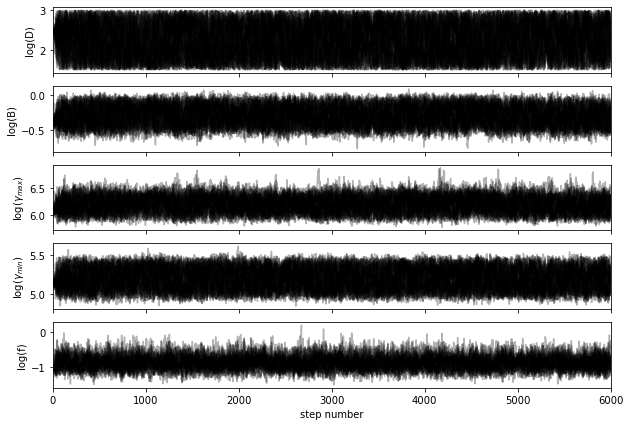

In [31]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["log(D)", "log(B)",  r"log($γ_{max}$)", r"log($γ_{min}$)", "log(f)"]
for i in range(ndim2): # ndim2 = number of parameters
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [32]:
# Steps needed for the chain to “forget” where it started
tau = sampler.get_autocorr_time()
print("tau=",tau) 
# Discard initial 100 steps,
# thin chain by about half the autocorrelation time (i.e.30 steps) & flatten the chain, so that we have a flat list of sample:
flat_samples2 = sampler.get_chain(discard=100, thin=30, flat=True)
print(flat_samples2.shape)

tau= [80.59230404 81.41864224 83.44658439 78.34727917 61.16853012]
(6272, 5)


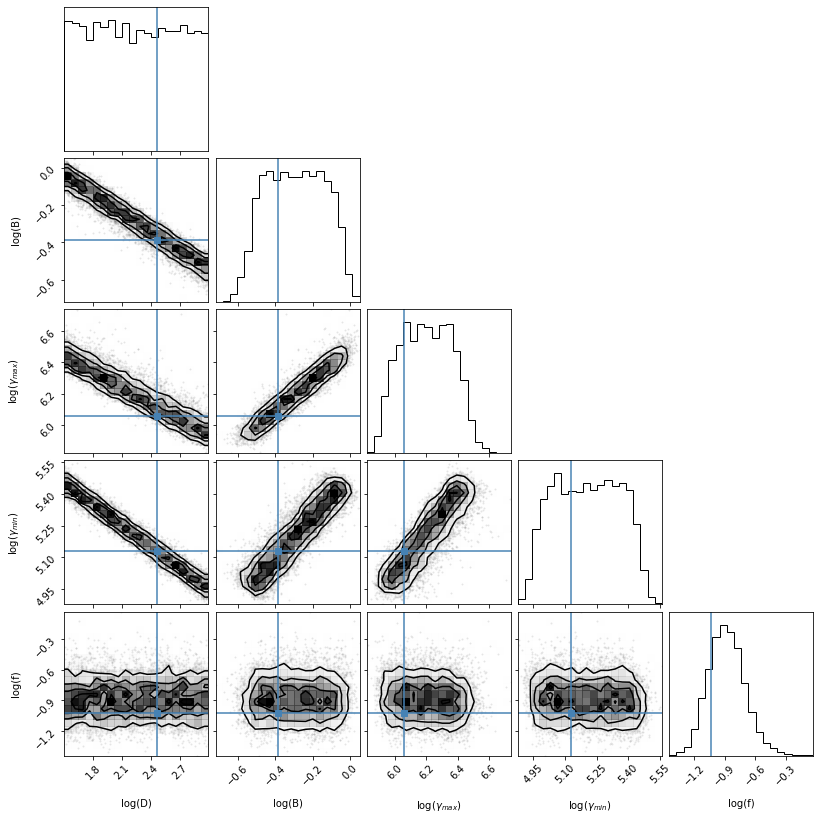

In [33]:
fig2 = corner.corner(
    flat_samples2, labels=labels, truths=[D_true2, B_true2, gmax_true2, gmin_true2, log_f_true2]
);
#plt.savefig('GRB211211A_MCMC2_corner.png')

In [34]:
# Quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions. 
for i in range(ndim2):
    mcmc = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [35]:
# de-log
labels_delog = ["D", "B",  r"$γ_{max}$", r"$γ_{min}$", "f"]
for i in range(ndim2):
    mcmc = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3e}_{{-{1:.3e}}}^{{+{2:.3e}}}"
    txt = txt.format(10**mcmc[1], 10**mcmc[1] - 10**mcmc[0] , 10**mcmc[2] - 10**mcmc[1], labels_delog[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Plot

In [36]:
t0 = np.linspace(1,50,100) # t_obs (sec)
t1 = np.linspace(1,200,200)
print("Model 2: γ_max(t) & γ_min")
print("D_true2, B_true2, gmax_true2, gmin_true2, log_f_true2 [all in log]")
print(solnx2)

Model 2: γ_max(t) & γ_min
D_true2, B_true2, gmax_true2, gmin_true2, log_f_true2 [all in log]
[2.461048091670658, -0.38721614328026455, 6.054995861529141, 5.128399268717806, -1.03]


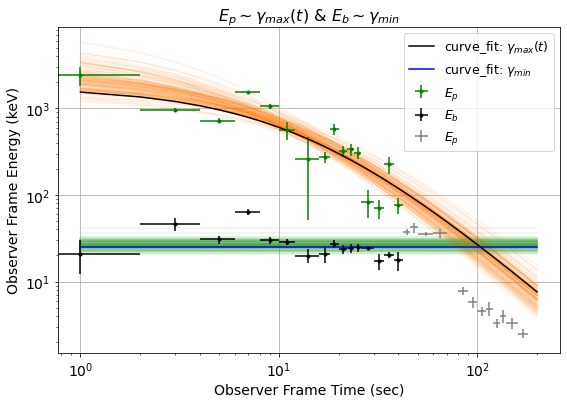

In [40]:
inds2 = np.random.randint(len(flat_samples2), size=100) #100 sample
fig2 = plt.figure(figsize=(9,6))
plt.title("$E_p \sim γ_{max}(t)$ & $E_b \sim γ_{min}$", fontsize=16)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Observer Frame Time (sec)", fontsize=14)
plt.ylabel("Observer Frame Energy (keV)", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
for ind in inds2:
    sample = flat_samples2[ind]
    plt.plot(t1, fit_E_gt(t1,10**sample[2],10**sample[1],10**sample[0]), "C1", alpha=0.1)
    Gmin0_i = [Eobs_fromg(10**sample[3], 10**sample[0], 10**sample[1]) for x in t1] 
    plt.plot(t1, Gmin0_i, "C2", alpha=0.1)
plt.errorbar(x1, y1, yerr=yerr1, xerr=TimeerA, fmt=".g", capsize=0, elinewidth=1.5, label="$E_p$")
plt.errorbar(x2, y2, yerr=yerr2, xerr=TimeerA, fmt=".k", capsize=0, elinewidth=1.5,label="$E_b$")
plt.errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', c="0.5", elinewidth=1.5,label="$E_p$")
plt.plot(t1, fit_E_gt(t1, 10**gmax_true2, 10**B_true2, 10**D_true2), "k", label="curve_fit: $γ_{max}(t)$")
Gmin0 = [Eobs_fromg(10**gmin_true2, 10**D_true2, 10**B_true2) for x in t1] 
plt.plot(t1, Gmin0, "b", label="curve_fit: $γ_{min}$")
plt.legend(fontsize=12.5)
#plt.savefig('GRB211211A_SpectralBreaks_MCMC2.png')

In [41]:
# if we want to plot again: save "inds"
#print(inds2)
f = open("inds2_t0.txt", "w")
f.write("ind,D,B,gmax,gmin,f\n")
for i in range(len(inds2)):
    f.write(f"{inds2[i]},")
    sample = flat_samples2[inds2[i]]
    f.write(f"{10**sample[0]},")
    f.write(f"{10**sample[1]},")
    f.write(f"{10**sample[2]},")
    f.write(f"{10**sample[3]},")
    f.write(f"{10**sample[4]}\n")
f.close()

data_inds2 = pd.read_csv('inds2_t0.txt', delimiter = ",")
data_inds2
#inds_txt = data_inds2["ind"]
#D_txt = data_inds2["D"]
#B_txt = data_inds2["B"]
#gmax_txt = data_inds2["gmax"]

,ind,D,B,gmax,gmin,f
0,3402,695.839710,0.347797,1.232476e+06,89874.477412,0.169537
1,1145,100.826656,0.588416,1.766590e+06,206162.750989,0.149013
2,3023,273.294883,0.392958,1.174125e+06,137795.745790,0.288906
3,3336,317.113381,0.377690,1.337038e+06,137914.159408,0.088146
4,3429,743.398578,0.259863,8.982794e+05,110086.066373,0.059221
...,...,...,...,...,...,...
95,4407,922.197134,0.318856,1.175300e+06,89205.564048,0.091936
96,6154,94.501043,0.633961,1.854158e+06,196785.025841,0.223376
97,5671,595.594246,0.337644,9.712427e+05,103135.483419,0.083745
98,3931,83.191073,0.542289,1.879543e+06,209388.990869,0.163232


In [42]:
# AIC criterion
k2 = 5 # parameters
log_prob_model2 = sampler.lnprobability
max_log_prob_model2 = np.max(log_prob_model2)
AIC2 = 2*k2 - 2*max_log_prob_model2
print("AIC for Model 2:", AIC2)

AIC for Model 2: 345.3449447741516


### AIC criterion

$AIC = 2\;k - 2\;ln(L)$

In [43]:
print(f"AIC for Model 1: {AIC1}")
print(f"AIC for Model 2: {AIC2}")
# Compare the models
if AIC1 < AIC2:
    print("Model 1 (γ_max(t) & γ_min(t)) is preferred, based on AIC.")
else:
    print("Model 2 (γ_max(t) & γ_min) is preferred, based on AIC.")

AIC for Model 1: 335.41360555378384
AIC for Model 2: 345.3449447741516
Model 1 (γ_max(t) & γ_min(t)) is preferred, based on AIC.


### Plot results

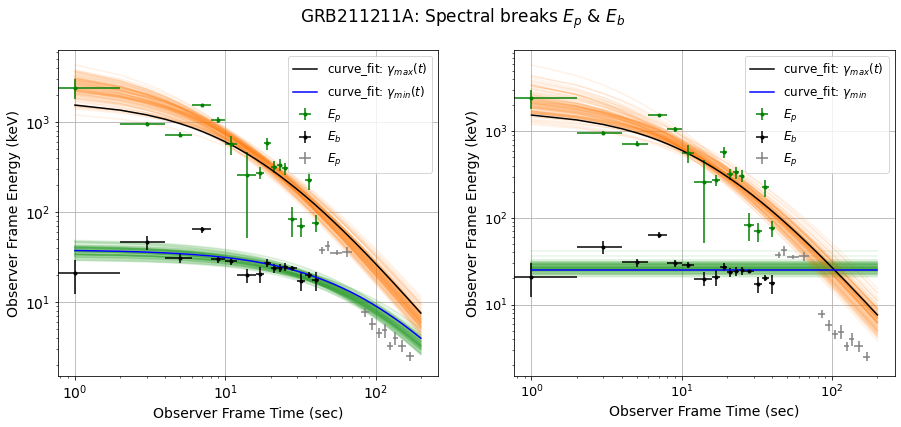

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle("GRB211211A: Spectral breaks $E_p$ & $E_b$", fontsize=17)
axes[0].set_xlabel("Observer Frame Time (sec)", fontsize=14)
axes[0].set_ylabel("Observer Frame Energy (keV)", fontsize=14)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].grid()
axes[1].set_xlabel("Observer Frame Time (sec)", fontsize=14)
axes[1].set_ylabel("Observer Frame Energy (keV)", fontsize=14)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[1].grid()

for ind in inds1:
    sample = flat_samples1[ind]
    axes[0].plot(t1, fit_E_gt(t1,10**sample[2],10**sample[1],10**sample[0]), "C1", alpha=0.1)
    axes[0].plot(t1, fit_E_gt(t1,10**sample[3],10**sample[1],10**sample[0]), "C2", alpha=0.1)
axes[0].errorbar(x1, y1, yerr=yerr1, xerr=TimeerA, fmt=".g", capsize=0, elinewidth=1.5, label="$E_p$")
axes[0].errorbar(x2, y2, yerr=yerr2, xerr=TimeerA, fmt=".k", capsize=0, elinewidth=1.5,label="$E_b$")
axes[0].errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', c="0.5", elinewidth=1.5,label="$E_p$")
axes[0].plot(t1, fit_E_gt(t1, 10**gmax_true1, 10**B_true1, 10**D_true1), "k", label="curve_fit: $γ_{max}(t)$")
axes[0].plot(t1, fit_E_gt(t1, 10**gmin_true1, 10**B_true1, 10**D_true1), "b", label="curve_fit: $γ_{min}(t)$")

for ind in inds2:
    sample = flat_samples2[ind]
    axes[1].plot(t1, fit_E_gt(t1,10**sample[2],10**sample[1],10**sample[0]), "C1", alpha=0.1)
    Gmin0_i = [Eobs_fromg(10**sample[3], 10**sample[0], 10**sample[1]) for x in t1] 
    axes[1].plot(t1, Gmin0_i, "C2", alpha=0.1)
axes[1].errorbar(x1, y1, yerr=yerr1, xerr=TimeerA, fmt=".g", capsize=0, elinewidth=1.5, label="$E_p$")
axes[1].errorbar(x2, y2, yerr=yerr2, xerr=TimeerA, fmt=".k", capsize=0, elinewidth=1.5,label="$E_b$")
axes[1].errorbar(TimeB,EpB,xerr=TimeerB,yerr=EperB, fmt='none', c="0.5", elinewidth=1.5,label="$E_p$")
axes[1].plot(t1, fit_E_gt(t1, 10**gmax_true2, 10**B_true2, 10**D_true2), "k", label="curve_fit: $γ_{max}(t)$")
Gmin0 = [Eobs_fromg(10**gmin_true2, 10**D_true2, 10**B_true2) for x in t1] 
axes[1].plot(t1, Gmin0, "b", label="curve_fit: $γ_{min}$")

axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)
#plt.savefig('GRB211211A_SpectralBreaks_MCMC12.png')

### $t_{syn}$  VS  $t_{cross}$

In [50]:
# Model 1
B_test = 5.193*(10**-1)
D_test = 1.794*(10**2)
gmax_test = 1.656*(10**6)
gmin_test = 1.874*(10**5)
tsyn_gmin_test = f.time_synB(gmin_test,B_test)/D_test
tsyn_gmax_test = f.time_synB(gmax_test,B_test)/D_test
print("t_syn(γ_min) =", tsyn_gmin_test,"s")
print("t_syn(γ_max) =", tsyn_gmax_test,"s")

t_syn(γ_min) = 85.35107550212881 s
t_syn(γ_max) = 9.658690548972789 s


In [51]:
Rstar = 10**13 #cm (page 8)
tcross_test = Rstar/c
print(tcross_test/D_test,"s")

1.8593313738397785 s


$t_{syn} > t_{cross}$ means that we have a **slow cooling regime**. <br>
The GRB Lightcurve has rapid changes in Luminosity, with timescales $\sim 1sec$, thus the synchrotron emission model can't describe the observed emission without taking into account the dynamical timescale of the electrons.